# Определение положение лица человека: фас или профиль

Базовый ноутбук для выполнения промежуточного контроля для модуля 3. "Компьютерное зрение".

Курс "[Технологии искусственного интеллекта для учителей информатики](https://edu.mipt.ru/ai/it2/)".

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Загружаем набор данных

In [ ]:
!wget -O train.zip https://www.dropbox.com/scl/fi/j1abedjqgbis6k0qb9g6s/train.zip?rlkey=9b8dk24ssrs966tc0d4np9ca9&dl=1

--2024-09-15 17:50:06--  https://www.dropbox.com/scl/fi/j1abedjqgbis6k0qb9g6s/train.zip?rlkey=9b8dk24ssrs966tc0d4np9ca9
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc134a51318d47919390b32d9fad.dl.dropboxusercontent.com/cd/0/inline/CaqRMbQlo0lpjjC4nUrpnHVK1f59q3R4TmvLfK2ce3mwUJcIgDTV25wKGWKwmM-OLer87kJBguY3QqRbrz_ROohmqUrXLtewKbDIE1T1XJakaetLkz3EgwbS-Als958wj6Y/file# [following]
--2024-09-15 17:50:07--  https://uc134a51318d47919390b32d9fad.dl.dropboxusercontent.com/cd/0/inline/CaqRMbQlo0lpjjC4nUrpnHVK1f59q3R4TmvLfK2ce3mwUJcIgDTV25wKGWKwmM-OLer87kJBguY3QqRbrz_ROohmqUrXLtewKbDIE1T1XJakaetLkz3EgwbS-Als958wj6Y/file
Resolving uc134a51318d47919390b32d9fad.dl.dropboxusercontent.com (uc134a51318d47919390b32d9fad.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to uc134a5131

In [ ]:
!unzip train.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/profile/p (5488).png  
  inflating: train/profile/p (5489).png  
  inflating: train/profile/p (549).png  
  inflating: train/profile/p (5490).png  
  inflating: train/profile/p (5491).png  
  inflating: train/profile/p (5492).png  
  inflating: train/profile/p (5493).png  
  inflating: train/profile/p (5494).png  
  inflating: train/profile/p (5495).png  
  inflating: train/profile/p (5496).png  
  inflating: train/profile/p (5497).png  
  inflating: train/profile/p (5498).png  
  inflating: train/profile/p (5499).png  
  inflating: train/profile/p (55).png  
  inflating: train/profile/p (550).png  
  inflating: train/profile/p (5500).png  
  inflating: train/profile/p (5501).png  
  inflating: train/profile/p (5502).png  
  inflating: train/profile/p (5503).png  
  inflating: train/profile/p (5504).png  
  inflating: train/profile/p (5505).png  
  inflating: train/profile/p (5506).png  
  inflating:

Определяем инструмент предварительной обработки изображений из набора данных

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((100, 100)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Загружаем набор данных

In [ ]:
data = datasets.ImageFolder("train", transform=transform)

**Делим набор данных на данные для обучения и проверки**

In [ ]:
# train - набор данных для обучения, 80%
# val - проверочный набор данных, 20%
train, val = random_split(data, [0.8, 0.2])

Количество изображений в наборе данных для обучения

In [ ]:
len(train)

19383

Количество изображений в проверочном наборе данных

In [ ]:
len(val)

4845

Создаем загрузчики данных

In [ ]:
# Размер мини-выборки
batch_size = 32

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Названия классов

In [ ]:
data.class_to_idx

{'enface': 0, 'profile': 1}

In [ ]:
classes = ['фас', 'профиль']

**Просматриваем примеры изображений**



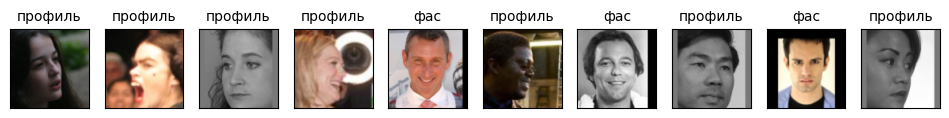

In [ ]:
nsamples=10

imgs, labels = next(iter(trainloader))

fig=plt.figure(figsize=(12,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    img = imgs[i] / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[i]], fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Создаем модель




In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [ ]:
device

'cuda'

Описываем класс для модели

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(80000, 16),
            nn.ReLU(),
            nn.Linear(16, 2))

    def forward(self, xb):
        return self.network(xb)

Создаем модель на основе описанного класса

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=80000, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)


## Обучаем модель

Задаем функцию ошибки - перекрестная энтропия



In [ ]:
loss_fn = nn.CrossEntropyLoss()

Задаем оптимизатор

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Определяем функцию для обучения нейронной сети



In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Включаем режим обучения
    model.train()
    # В цикле получаем все мини-выборки
    # X - изображение
    # y - номер класса
    for batch, (X, y) in enumerate(dataloader):
        # Передаем данные на устройство
        X, y = X.to(device), y.to(device)
        # Обнуляем значения градиента
        optimizer.zero_grad()

        # Расчитываем данные на выходе из нейронной сети
        pred = model(X)

        # Расчитываем значение ошибки
        loss = loss_fn(pred, y)

        # Обратное распространение ошиби
        loss.backward()

        # Выполняем шаг обучения (изменение весов)
        optimizer.step()

        # Печатаем прогресс каждые 50 мини-выборок
        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Ошибка: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Определяем функцию для проверки качества работы нейронной сети на тестовом наборе данных

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Включаем режим оценки качества модели
    model.eval()
    # Начальные значения
    test_loss, correct = 0, 0
    # Для оценки качества работы не нужно рассчитывать градиент
    with torch.no_grad():
        # В цикле проходим по мини-выборкам из тестового набора данных
        for X, y in dataloader:
            # Передаем данные на устройство
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Качество на проверочном наборе данных: \n Доля правильных ответов: {(100*correct):>0.1f}%, средняя ошибка: {test_loss:>8f} \n")

Обучаем модель в течение 2 эпох



In [ ]:
epochs = 2
for t in range(epochs):
    print(f"Эпоха {t+1}\n-------------------------------")
    # Обучение модели
    train(trainloader, model, loss_fn, optimizer)
    # Оценка качества работы на проверочном наборе данных
    test(valloader, model, loss_fn)
print("Обучение завершено!")

Эпоха 1
-------------------------------
Ошибка: 0.686513  [   32/19383]
Ошибка: 0.220591  [ 1632/19383]
Ошибка: 0.093348  [ 3232/19383]
Ошибка: 0.040104  [ 4832/19383]
Ошибка: 0.215213  [ 6432/19383]
Ошибка: 0.056922  [ 8032/19383]
Ошибка: 0.022867  [ 9632/19383]
Ошибка: 0.122878  [11232/19383]
Ошибка: 0.073820  [12832/19383]
Ошибка: 0.023958  [14432/19383]
Ошибка: 0.037348  [16032/19383]
Ошибка: 0.052520  [17632/19383]
Ошибка: 0.079118  [19232/19383]
Качество на проверочном наборе данных: 
 Доля правильных ответов: 99.2%, средняя ошибка: 0.030003 

Эпоха 2
-------------------------------
Ошибка: 0.003202  [   32/19383]
Ошибка: 0.002575  [ 1632/19383]
Ошибка: 0.012203  [ 3232/19383]
Ошибка: 0.002134  [ 4832/19383]
Ошибка: 0.011172  [ 6432/19383]
Ошибка: 0.018433  [ 8032/19383]
Ошибка: 0.008803  [ 9632/19383]
Ошибка: 0.007704  [11232/19383]
Ошибка: 0.013332  [12832/19383]
Ошибка: 0.000305  [14432/19383]
Ошибка: 0.003888  [16032/19383]
Ошибка: 0.004489  [17632/19383]
Ошибка: 0.000801  [1

## Распознавание тестового набора данных

### Загрузка тестового набора данных

In [ ]:
!wget -O test.zip https://www.dropbox.com/scl/fi/bolka1qv2ylazu243arhn/test.zip?rlkey=02uwzpg5mt27bnmmq0056qmgk&dl=1

--2024-09-15 17:52:46--  https://www.dropbox.com/scl/fi/bolka1qv2ylazu243arhn/test.zip?rlkey=02uwzpg5mt27bnmmq0056qmgk
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3e1cce3332c31e8ef30f4a67b8.dl.dropboxusercontent.com/cd/0/inline/CapceZdSODHiuge7XpDi27wb-VkTfWFz4tdiZq2i1pTKHkbnqlPlBt6zD4UH5Oxv-rGWEZTYPGIHYYtP_vSuidVKRRyeduMQex8-fIV2CvK-PCTN1w3ovPAmRT27aOj63i4/file# [following]
--2024-09-15 17:52:47--  https://uc3e1cce3332c31e8ef30f4a67b8.dl.dropboxusercontent.com/cd/0/inline/CapceZdSODHiuge7XpDi27wb-VkTfWFz4tdiZq2i1pTKHkbnqlPlBt6zD4UH5Oxv-rGWEZTYPGIHYYtP_vSuidVKRRyeduMQex8-fIV2CvK-PCTN1w3ovPAmRT27aOj63i4/file
Resolving uc3e1cce3332c31e8ef30f4a67b8.dl.dropboxusercontent.com (uc3e1cce3332c31e8ef30f4a67b8.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to uc3e1cce3

In [ ]:
!unzip test.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test/ 5470.png          
  inflating: test/ 5471.png          
  inflating: test/ 5472.png          
  inflating: test/ 5473.png          
  inflating: test/ 5474.png          
  inflating: test/ 5475.png          
  inflating: test/ 5476.png          
  inflating: test/ 5477.png          
  inflating: test/ 5478.png          
  inflating: test/ 5479.png          
  inflating: test/ 548.png           
  inflating: test/ 5480.png          
  inflating: test/ 5481.png          
  inflating: test/ 5482.png          
  inflating: test/ 5483.png          
  inflating: test/ 5484.png          
  inflating: test/ 5485.png          
  inflating: test/ 5486.png          
  inflating: test/ 5487.png          
  inflating: test/ 5488.png          
  inflating: test/ 5489.png          
  inflating: test/ 549.png           
  inflating: test/ 5490.png          
  inflating: test/ 5491.png          
  inflating: test/ 5

### Dataset и DataLoader

Создадим свой класс для загрузки данных из папки

Наследуем от `Dataset`

Особенности написанного класса

* считываются все изображения в папке `img_dir` по индексам, обозначенным в файле `txt_path` (`samples`)
* из файла `txt_path` также берутся метки классов (`target`)

In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, txt_path='/content/submission.csv', img_dir='/content/test',
                 transform=None, test=False):
        df = pd.read_csv(txt_path, sep=',', index_col=0)
        self.img_names = df.index.values
        self.df = df
        self.txt_path = txt_path
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def get_image_from_folder(self, name):

        image = Image.open(os.path.join(self.img_dir, " " + name))
        return image

    def __getitem__(self, idx):
        sample = self.get_image_from_folder(self.img_names[idx])
        if self.transform is not None:
            sample = self.transform(sample)
        target = self.df.label[idx]
        return sample, target

Скачиваем шаблон файла для отправки решения

In [ ]:
!wget -O submission.csv https://www.dropbox.com/scl/fi/skb8nlrchtj26jlxg7arm/submission.csv?rlkey=druf290002naxxzeccws7ffnu&dl=0

--2024-09-15 17:53:08--  https://www.dropbox.com/scl/fi/skb8nlrchtj26jlxg7arm/submission.csv?rlkey=druf290002naxxzeccws7ffnu
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3ccfd8e8e712d148a62d321f8e.dl.dropboxusercontent.com/cd/0/inline/CaqR-SFkRjR6xAAv-IOSteqIPWlzcaaqEmoTS6BcyAK2Lv4gam0CtD5HlspOya1GXQhEINuEKc9MJG4QgGeafsTQ86sFfxUa-hb0GYUdG_6-hOldG_p2erkc-7Ixf-yiKGg/file# [following]
--2024-09-15 17:53:09--  https://uc3ccfd8e8e712d148a62d321f8e.dl.dropboxusercontent.com/cd/0/inline/CaqR-SFkRjR6xAAv-IOSteqIPWlzcaaqEmoTS6BcyAK2Lv4gam0CtD5HlspOya1GXQhEINuEKc9MJG4QgGeafsTQ86sFfxUa-hb0GYUdG_6-hOldG_p2erkc-7Ixf-yiKGg/file
Resolving uc3ccfd8e8e712d148a62d321f8e.dl.dropboxusercontent.com (uc3ccfd8e8e712d148a62d321f8e.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to uc3cc

In [ ]:
!head submission.csv

id,label
1.png,1
2.png,1
3.png,1
5.png,1
6.png,1
7.png,1
8.png,1
9.png,1
10.png,1


In [ ]:
submission = pd.read_csv('submission.csv', sep=',', index_col=0)
submission

,label
id,
1.png,1
2.png,1
3.png,1
5.png,1
6.png,1
...,...
11578.png,1
11579.png,1
11580.png,1


Создаем DataSet

In [ ]:
test_dataset = CustomDataSet(txt_path='/content/submission.csv',
                             img_dir='/content/test',
                             transform=transform)

Создаем загрузчик данных.
Важно - данные в этом случае не надо перемешивать, поскольку при загрузке файла с ответом необходим строгий порядок.

In [ ]:
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=1,
                          )

Реализуем предсказание модели на тестовых данных

In [ ]:
test_predictions = []

for inputs, _ in tqdm(test_loader):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(preds.argmax(dim = 1).data.cpu().numpy())

test_predictions = np.concatenate(test_predictions)


  0%|          | 0/360 [00:00<?, ?it/s]<ipython-input-24-61542e163a1c>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = self.df.label[idx]
100%|██████████| 360/360 [00:44<00:00,  8.05it/s]


In [ ]:
test_predictions[:100]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

Откроем файл для загрузки (предсказания заполнены единицами)

In [ ]:
submission

,label
id,
1.png,1
2.png,1
3.png,1
5.png,1
6.png,1
...,...
11578.png,1
11579.png,1
11580.png,1


Поместим в файл предсказания модели

In [ ]:
submission.label = test_predictions
submission

,label
id,
1.png,0
2.png,0
3.png,0
5.png,1
6.png,0
...,...
11578.png,1
11579.png,0
11580.png,0


## Готовим итоговый файл

In [ ]:
submission.to_csv('/content/cnn_submission.csv',
                  index=True, sep = ',')